Model and Data Loading

In [1]:
# Initate Model and Load Data
"""
This code uses the Planning Operator on the Maze dataset described in the paper "Planning Operator: Generalizable Robot Motion Planning via Operator Learning"
"""

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt
from torchsummary import summary

import os
os.chdir('..')

import matplotlib.pyplot as plt
from models.utilities import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io
import sys
from itertools import chain


from models.TrainPlanningOperator2D import PlanningOperator2D
from models.TrainPlanningOperator2D import smooth_chi
import time

def tic():
  return time.time()


def toc(tstart):
   return (time.time() - tstart)



lrs = [8e-3]
gammas = [0.5]
wds = [3e-6]
smooth_coefs = [5.]
smooth_coef = smooth_coefs[0]
# experiments to be replicated with different seeds
seeds = [5, 2000, 14000, 16000, 100000]
seeds = [seeds[0]]

################################################################
#                       configs
################################################################
Ntotal = 5054*10+1000*10
ntrain = 5054*10
ntest = Ntotal-ntrain

batch_size = 10

epochs = 501
scheduler_step = 100
tol_early_stop = 500

modes = 8
width = 32
nlayers = 5

################################################################
# load data and data normalization
################################################################
t1 = default_timer()

sub = 1
Sx = int(((28 - 1) / sub) + 1)
Sy = Sx

mask = np.load('dataset/vin_dataset_27x27/mask.npy')
mask = torch.tensor(mask, dtype=torch.float)
dist_in = np.load('dataset/vin_dataset_27x27/dist_in.npy')
dist_in = torch.tensor(dist_in[:Ntotal, :, :], dtype=torch.float)
input = smooth_chi(mask, dist_in, smooth_coef)
# input = mask

output = np.load('dataset/vin_dataset_27x27/output.npy')
output = torch.tensor(output, dtype=torch.float)

goals = np.load('dataset/vin_dataset_27x27/goals.npy')
goals = torch.tensor(goals, dtype=torch.float)



mask_train = mask[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
mask_test = mask[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

mask_train = mask_train.reshape(ntrain, Sx, Sy, 1)
mask_test = mask_test.reshape(ntest, Sx, Sy, 1)

chi_train = input[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
chi_test = input[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

chi_train = chi_train.reshape(ntrain, Sx, Sy, 1)
chi_test = chi_test.reshape(ntest, Sx, Sy, 1)

y_train = output[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
y_test = output[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

y_train = y_train.reshape(ntrain, Sx, Sy, 1)
y_test = y_test.reshape(ntest, Sx, Sy, 1)

goals_train = goals[:ntrain]
goals_test = goals[-ntest:]

goals_train = goals_train.reshape(ntrain, 2, 1)
goals_test = goals_test.reshape(ntest, 2, 1)

myloss = LpLoss(size_average=False)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_train, chi_train, y_train, goals_train),
                                            batch_size=batch_size,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_test, chi_test, y_test, goals_test),
                                          batch_size=batch_size,
                                          shuffle=False)




In [2]:


model = PlanningOperator2D(modes, modes, width, nlayers)
model.load_state_dict(torch.load("trained_models/planningoperator_vin_maze27x27_symmetric_norm/n50540_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model_depth4.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



PlanningOperator2D(
  (fc0): Linear(in_features=2, out_features=32, bias=True)
  (conv0): SpectralConv2d()
  (w0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv1): SpectralConv2d()
  (w1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv2): SpectralConv2d()
  (w2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): SpectralConv2d()
  (w3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv4): SpectralConv2d()
  (w4): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=32, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

In [3]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}') 

Total number of parameters: 690432


In [4]:
count = 0
out1_train_l2 = 0
out1_test_l2 = 0

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(train_loader):
        mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
        
        out1 = model(chi, gg)
        out1 = out1*mask
        out1_train_l2 += myloss(out1, ground_truth).item()
        count += 1


# Compute overall RMS errors
train_error = (out1_train_l2 / (count*batch_size))

count = 0
out1_train_l2 = 0
out1_test_l2 = 0

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
        
        out1 = model(chi, gg)
        out1 = out1*mask
        out1_test_l2 += myloss(out1, ground_truth).item()
        count += 1


# Compute overall RMS errors
test_error = (out1_test_l2 / (count*batch_size))

print("Train Error:",train_error,
      "\nTest Error:",test_error)

Train Error: 0.027184087852975054 
Test Error: 0.045669458289444444


Plotting all predictions against ground truth

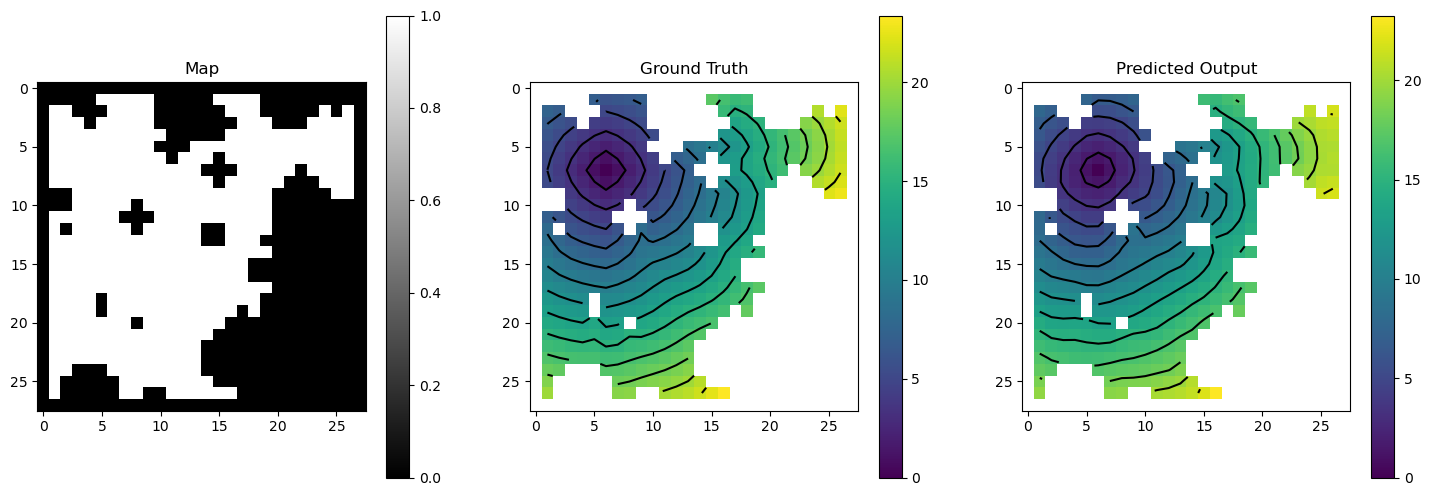

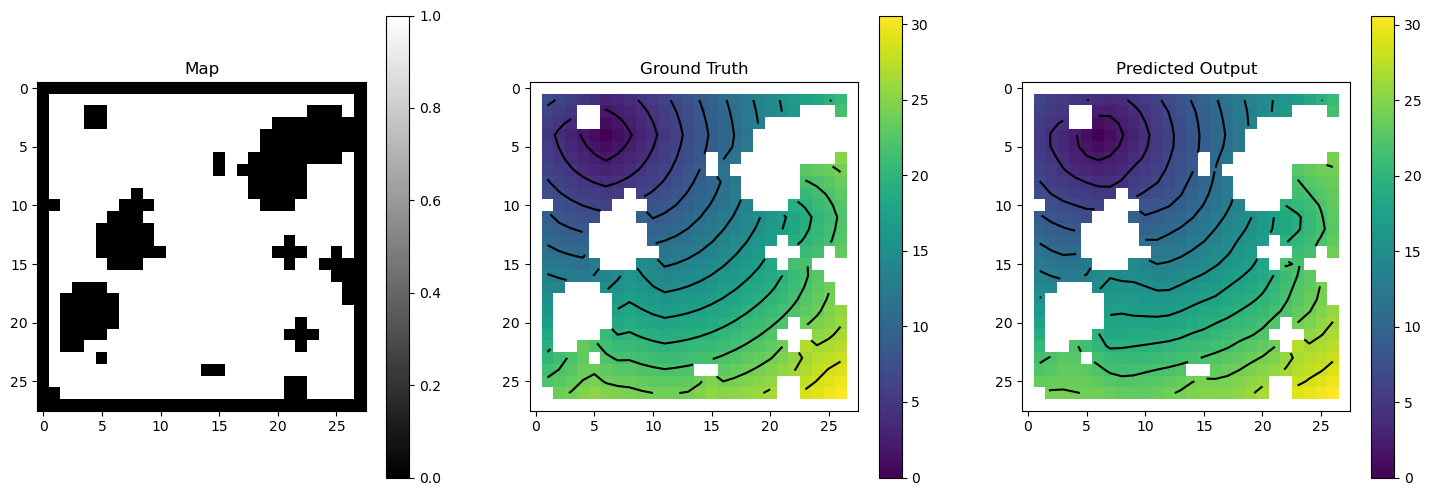

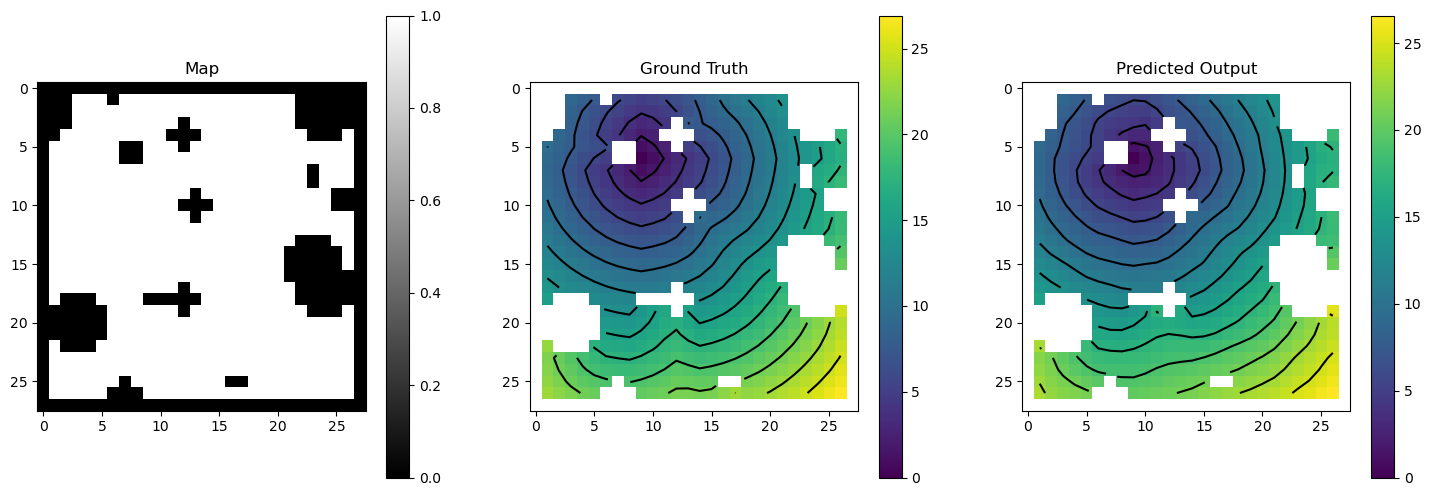

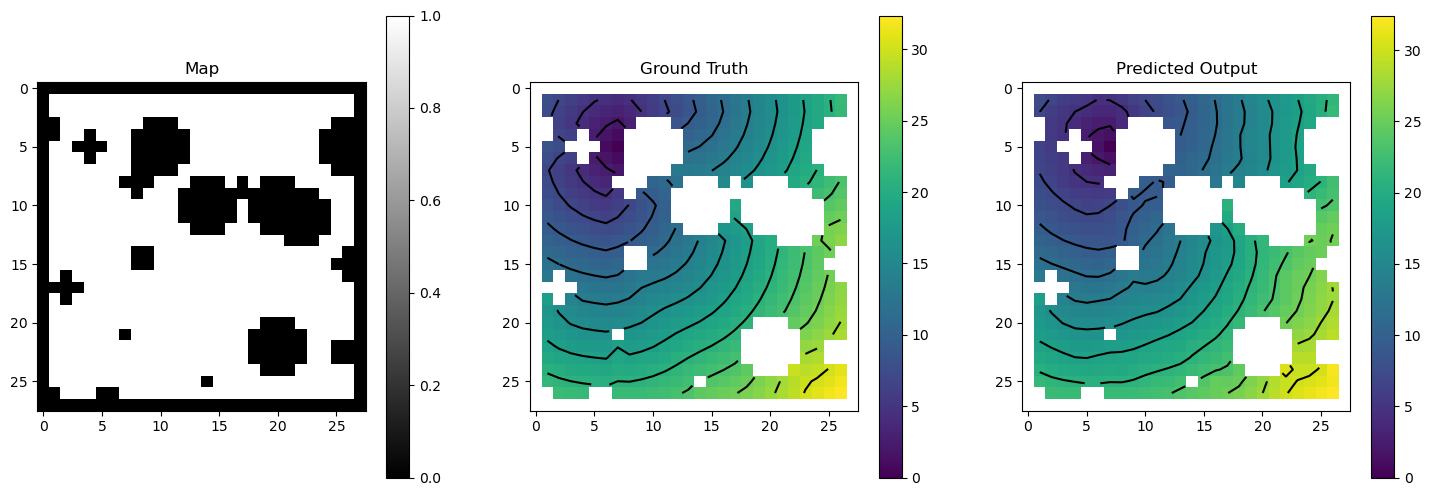

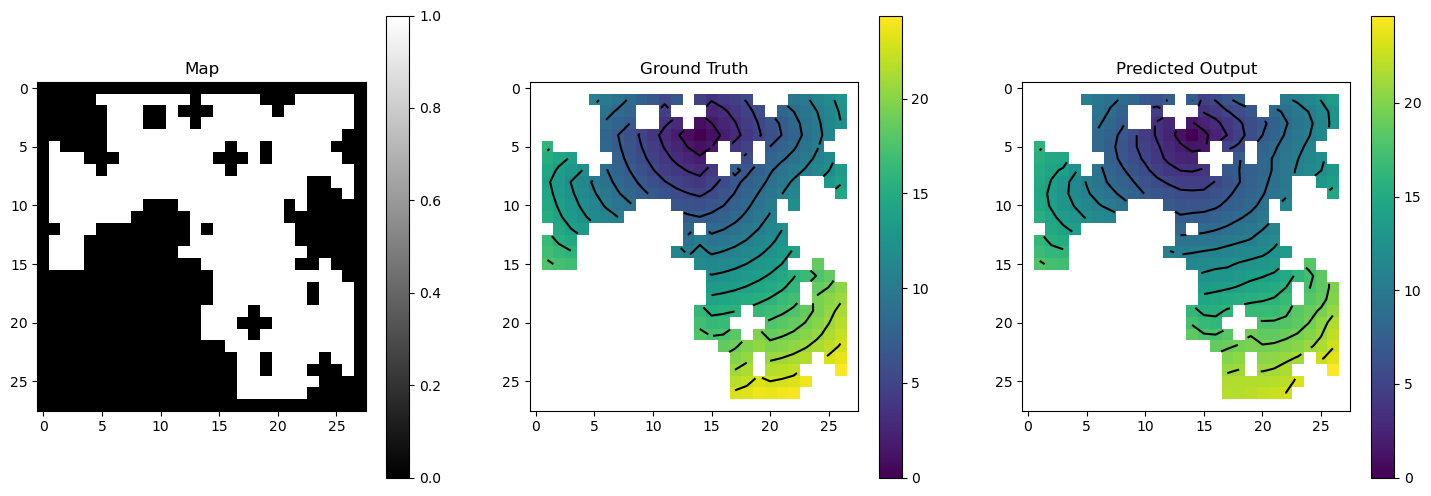

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

mean_error = 0
count = 0
normalization = 1 / 1.0  # Adjust or calculate as needed

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
        predicted_output = model(chi, gg)
        
        # Replace invalid values with NaN instead of Inf
        predicted_output = torch.where(mask == 0, torch.tensor(float('nan'), device=device), predicted_output)
        ground_truth = torch.where(mask == 0, torch.tensor(float('nan'), device=device), ground_truth)
        
        absolute_error = (ground_truth - predicted_output * normalization)

        if batch_id == 5:
            break

        # Convert tensors to numpy arrays
        mask_np = mask[0, :, :, 0].cpu().numpy()
        ground_truth_np = ground_truth[0, :, :, 0].cpu().numpy()
        predicted_output_np = predicted_output[0, :, :, 0].cpu().numpy()

        # Plot results for the current batch
        plt.figure(figsize=(18, 6))
        titles = ['Map', 'Ground Truth', 'Predicted Output']
        images = [mask_np, ground_truth_np, predicted_output_np]

        for i in range(3):
            plt.subplot(1, 3, i+1)
            img = plt.imshow(images[i], cmap='viridis' if i > 0 else 'gray', vmin=0, vmax=np.nanmax(images[i]))

            # Compute valid min/max values for contours (ignoring NaN)
            min_val = np.nanmin(images[i])
            max_val = np.nanmax(images[i])
            
            # Define contour levels (ensuring sufficient spacing)
            contour_levels = np.linspace(min_val, max_val, num=15)  # 15 contour levels
            
            if i > 0:
                # Overlay contour lines with proper color contrast
                contour_lines = plt.contour(images[i], levels=contour_levels, colors='black', linewidths=1.5)
                #plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.1f", colors='white')  # Label contours

            plt.title(f'{titles[i]}')
            plt.colorbar(img)  # Ensure colorbar is linked to the imshow plot

        plt.show()


Gradient Descent Function Definition

In [ ]:
# Define gradient descent function
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

action_vecs = np.asarray([[-1, 0], [1, 0], [0, 1], [0, -1],
                            [-1, 1], [-1, -1], [1, 1], [1, -1]])

#   # Create a custom colormap that is inverted
cmap = plt.cm.viridis  # Choose the colormap you want to invert
cmap_inverted = LinearSegmentedColormap.from_list("inverted_viridis", cmap(np.linspace(1, 0, 256)))

import matplotlib.pyplot as plt
import numpy as np

def perform_gradient_descent(value_function, start_point, learning_rate, num_steps, goal_point, plotsuccess=False, plotfails=False):
    if plotsuccess or plotfails:
        plt.figure(figsize=(8, 8))
        plt.imshow(value_function, cmap=cmap_inverted, vmin=0, vmax=50, aspect='equal', origin='lower')  # Transpose value_function
        plt.colorbar()

        # Annotate start and goal positions
        plt.scatter(start_point[1], start_point[0], c='blue', marker='o', label='Start')
        plt.scatter(goal_point[1], goal_point[0], c='green', marker='x', label='Goal')
        plt.legend(loc='upper right')

    path_length = 0
    path_points = [start_point.copy()]
    visited_points = set()

    current_point = start_point.copy()

    for step in range(num_steps):
        best_gradient = np.inf
        best_action = None

        for action in action_vecs:
            new_point = current_point + learning_rate * action
            new_point_indices = np.round(new_point).astype(int)
            x_index, y_index = new_point_indices[0], new_point_indices[1]

            if (0 <= x_index < value_function.shape[0] and 0 <= y_index < value_function.shape[1] and
                    (x_index, y_index) not in visited_points):
                gradient = value_function[x_index, y_index]  # Note the change here
                if gradient < best_gradient:
                    best_gradient = gradient
                    best_action = action

        if best_gradient > 100:
            if plotfails:
                plt.plot([p[1] for p in path_points], [p[0] for p in path_points], 'ro-', markersize=2)  # Reversed plotting
                plt.gca().set_aspect('equal', adjustable='box')
                plt.show()
            return False, 0  

        if best_action is not None:
            current_point += learning_rate * best_action
            path_length += np.linalg.norm(learning_rate * best_action)
            path_points.append(current_point.copy())
            visited_points.add(tuple(np.round(current_point).astype(int)))
            if np.array_equal(np.round(current_point).astype(int), np.round(goal_point).astype(int)):
                if plotsuccess:
                    plt.plot([p[1] for p in path_points], [p[0] for p in path_points], 'ro-', markersize=2, label='Path')  # Reversed plotting
                    plt.gca().set_aspect('equal', adjustable='box')
                    plt.legend(loc='upper right')
                    plt.show()
                return True, path_length  # Success
        else:
            if plotfails:
                plt.plot([p[1] for p in path_points], [p[0] for p in path_points], 'ro-', markersize=2, label='Path')  # Reversed plotting
                plt.gca().set_aspect('equal', adjustable='box')
                # plt.legend(loc='upper right')
                plt.show()
            return False, 0  # No valid action found

    if plotfails:    
        plt.plot([p[1] for p in path_points], [p[0] for p in path_points], 'ro-', markersize=2, label='Path')  # Reversed plotting
        plt.gca().set_aspect('equal', adjustable='box')
        # plt.legend(loc='upper right')
        plt.show()        
    return False, 0  


<Figure size 1800x600 with 0 Axes>

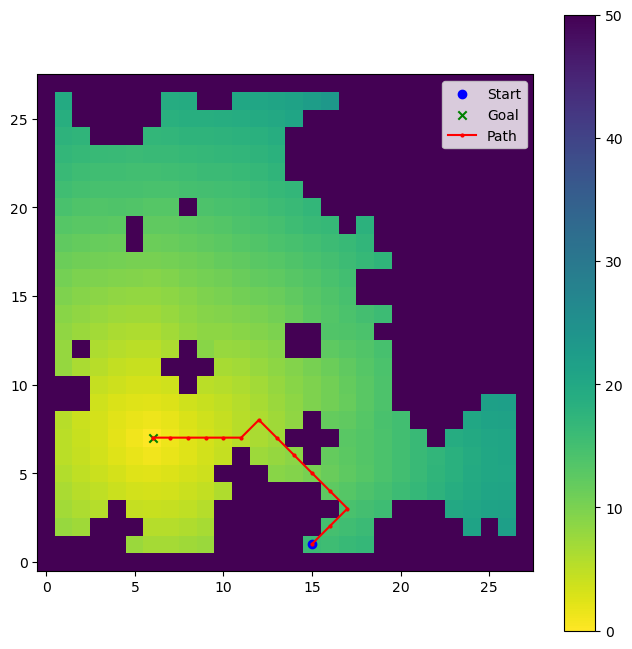

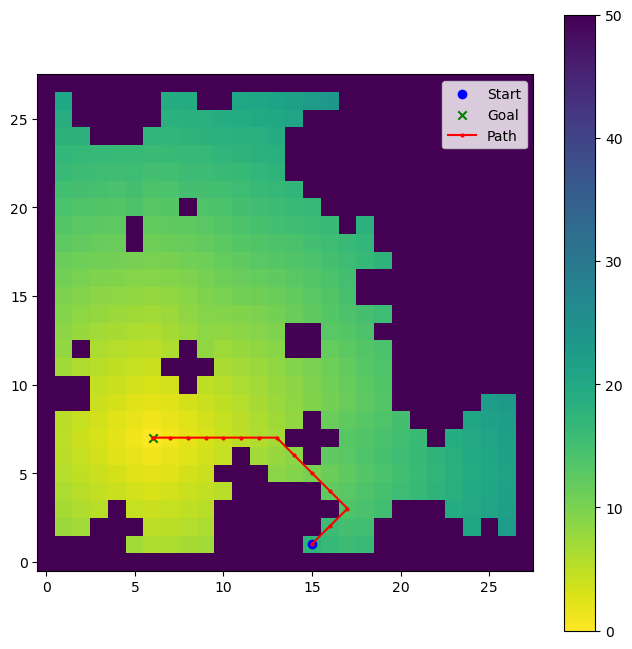

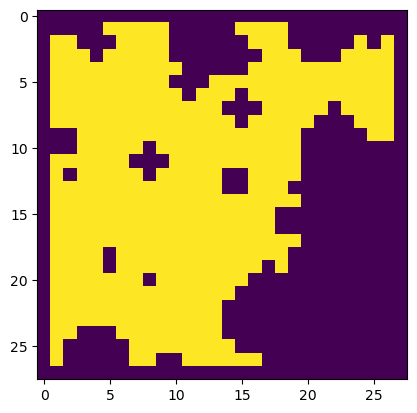

In [ ]:
mean_error = 0
count = 0
normalization = 1/1.0  # Adjust or calculate as needed

with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
        predicted_output = model(chi, gg)
        predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output) 
        ground_truth = torch.where(mask == 0, torch.tensor(float('inf')), ground_truth)
        absolute_error = (ground_truth - predicted_output * normalization)
        if batch_id == 1:
            break

        # Plot results for the current batch
        plt.figure(figsize=(18, 6))
        titles = ['Map', 'Ground Truth', 'Predicted Output']
        images = [
            mask[0, :, :, 0].cpu().numpy(),
            ground_truth[0, :, :, 0].cpu().numpy(),
            predicted_output[0, :, :, 0].cpu().numpy(),
        ]

        map = mask[0, :, :, 0].cpu().numpy()
        value_pred = np.clip(predicted_output[0, :, :, 0].cpu().numpy(),0,50)
        value_truth = np.clip(ground_truth[0, :, :, 0].cpu().numpy(),0,50)

        start_point = [1,15]
        goal = [7,6]
        learning_rate = 1
        num_steps = 1000

        success,lenght = perform_gradient_descent(value_pred,start_point, learning_rate, num_steps, goal, plotsuccess=True)
        success,lenght = perform_gradient_descent(value_truth,start_point, learning_rate, num_steps, goal, plotsuccess=True)

        plt.imshow(map)
        


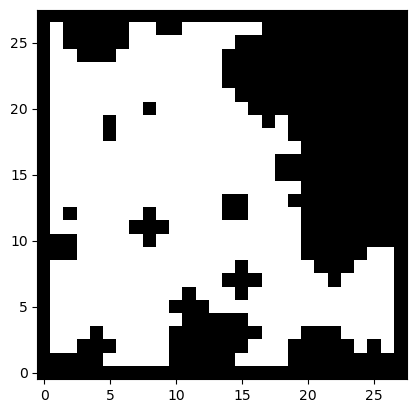

In [ ]:
plt.imshow(map, cmap='gray', origin="lower")

In [7]:
# Define signed distance function
def calculate_signed_distance(velocity_matrix):
    # Find the indices of obstacles
    obstacle_indices = np.where(velocity_matrix == 0)

    # Check if there are no obstacles
    if obstacle_indices[0].size == 0:
        # Handle the case when there are no obstacles
        return np.zeros_like(velocity_matrix)

    # Create a meshgrid of indices
    i, j = np.meshgrid(np.arange(velocity_matrix.shape[1]), np.arange(velocity_matrix.shape[0]), indexing='ij')  # Note the change in the order of indices
    
    # Calculate distances to obstacles using vectorized operations
    distances = np.sqrt((obstacle_indices[0][:, None, None] - i[None, :, :])**2 + (obstacle_indices[1][:, None, None] - j[None, :, :])**2)

    # Find the minimum distance for each point
    signed_distance = np.min(distances, axis=0)
    return signed_distance


In [8]:
success_count = 0
count = 0
averagepath = 0
start_positions = []
nodesexplored = 0
success_time = 0

from scipy.io import loadmat
testing_data_28x28 = loadmat('gridworld_28_test.mat')
testing_data_28x28_maps = testing_data_28x28["all_im_data"]
testing_data_28x28 = testing_data_28x28["all_states_xy"]


In [9]:

# output = predicted_output
for batch_idx, (mask, chi, ground_truth, gg) in enumerate(test_loader):
    ss = gg.clone()
    gg1 = gg.clone()
    for i in range(0,10):
        temp_tensor = torch.from_numpy(testing_data_28x28[batch_idx][0][-1].reshape(2,1))
        gg1[i, :] = torch.flip(temp_tensor, dims=[0])-1
        temp_tensor = torch.from_numpy(testing_data_28x28[batch_idx][0][0].reshape(2,1))
        ss[i, :] = torch.flip(temp_tensor, dims=[-1])-1

    mask, chi, ground_truth, gg, gg1 = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device), gg1.to(device)
    start_point = np.flip(ss[0,:,0].cpu().detach().numpy())
    learning_rate = 1
    num_steps = 100
    goal = gg1[0,:,0].cpu().detach().numpy()
    goal = [goal[0],goal[1]]

    t0 = tic()
    predicted_output = model(chi[0].unsqueeze(0),gg1[0].unsqueeze(0))
    predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output)
    value_function = predicted_output[0,:,:,0].cpu().detach().numpy()
    ground_truth = torch.where(mask == 0, torch.tensor(float('inf')), ground_truth)
    value_function_truth = ground_truth[0,:,:,0].cpu().detach().numpy()
    success,lenght = perform_gradient_descent(value_function,start_point, learning_rate, num_steps, goal)
    dt = toc(t0)
    success_time+=dt


    if(success):
        success_count+=1

    else:
        
        failedmask = testing_data_28x28_maps.reshape(1000,28,28)[batch_idx,:,:]

        failedsdf = calculate_signed_distance(failedmask)
        failedmask = torch.tensor(failedmask, dtype=torch.float)
        failedmask = failedmask.unsqueeze(0).unsqueeze(-1).expand(1, 28, 28, 1)
        failedsdf = torch.tensor(failedsdf, dtype=torch.float)
        failedsdf = failedsdf.unsqueeze(0).unsqueeze(-1).expand(1, 28, 28, 1)
        input = smooth_chi(failedmask, failedsdf, smooth_coef)
        input = input.to(device)
        failedmask = failedmask.to(device)
        failed_out = model(input[0].unsqueeze(0),gg1[0].unsqueeze(0))
        failed_out = torch.where(failedmask == 0, torch.tensor(float('inf')), failed_out)
        value_function = failed_out[0,:,:,0].cpu().detach().numpy()
        success,lenght = perform_gradient_descent(value_function,start_point, learning_rate, num_steps, goal)


        if(success):
            success_count+=1

    count+=1

print("Success Rate:",(success_count/count)*100,"%")
print("Average Time Taken:",(success_time/1000))


Success Rate: 99.3 %
Average Time Taken: 0.004167433023452759


Testing Triangular Inequality

In [ ]:
import random
success_count = 0
count = 0
for batch_idx, (mask, chi, ground_truth, gg) in enumerate(test_loader):
    count+=1
    mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
    predicted_output = model(chi,gg)
    predicted_output = torch.where(mask == 0, torch.tensor(float('inf')), predicted_output)
    ground_truth = torch.where(mask == 0, torch.tensor(float('inf')), ground_truth)
    passable_indices = np.argwhere(mask[0,:,:,0].cpu().numpy() == 1)
    dg1p = dg2p = dg1g2 = float("inf")
    while (dg1p>10e6) and (dg2p>10e6) and (dg1g2>10e6):
        random_index = random.choice(passable_indices)
        dg1p = predicted_output[0,random_index[0],random_index[1],0]
        dg2p = predicted_output[1,random_index[0],random_index[1],0]
        dg1g2 = predicted_output[0,int(gg[1,0,0]),int(gg[1,1,0]),0]
           
    if(torch.round(dg1p,decimals=2) <= torch.round(dg2p,decimals=2) + torch.round(dg1g2,decimals=2)) and (torch.round(dg1g2, decimals=2) <= torch.round(dg2p,decimals=2) + torch.round(dg1p, decimals=2)) and (torch.round(dg2p,decimals=2) <= torch.round(dg1p,decimals=2) + torch.round(dg1g2, decimals=2)):
        success_count+=1
    else:
        print("Does not follow triangular inequality")
        break    

    
print(success_count/count)        

1.0
